# Clustering RNA-Seq with Deep Learning

### Why unsupervised makes sense

>Your goal is to discover rare subtypes in gene expression data.

>These subtypes are not pre-labeled in reality; you don’t “know” them ahead of time.

>So you want the model to learn patterns/clusters in the data without supervision.

### Labels (df2) can then be used to:

>Check if discovered clusters match known classes.

>Interpret biological relevance (e.g., survival, treatment response).

>This is exactly unsupervised learning + interpretability.

In [ ]:
#Libraries
from sklearn.model_selection import KFold
from copy import deepcopy as dc
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.special import comb
import matplotlib.pyplot as plt

In [ ]:
# Load the csv data from the specified path
df1 = pd.read_csv("/content/data.csv")
print(df1.shape)
df1

(801, 20532)


,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.000000
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.000000
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.000000
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.000000
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,sample_796,0.0,1.865642,2.718197,7.350099,10.006003,0.0,6.764792,0.496922,0.0,...,6.088133,9.118313,10.004852,4.484415,9.614701,12.031267,9.813063,10.092770,8.819269,0.000000
797,sample_797,0.0,3.942955,4.453807,6.346597,10.056868,0.0,7.320331,0.000000,0.0,...,6.371876,9.623335,9.823921,6.555327,9.064002,11.633422,10.317266,8.745983,9.659081,0.000000
798,sample_798,0.0,3.249582,3.707492,8.185901,9.504082,0.0,7.536589,1.811101,0.0,...,5.719386,8.610704,10.485517,3.589763,9.350636,12.180944,10.681194,9.466711,4.677458,0.586693
799,sample_799,0.0,2.590339,2.787976,7.318624,9.987136,0.0,9.213464,0.000000,0.0,...,5.785237,8.605387,11.004677,4.745888,9.626383,11.198279,10.335513,10.400581,5.718751,0.000000


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20532 entries, Unnamed: 0 to gene_20530
dtypes: float64(20531), object(1)
memory usage: 125.5+ MB


In [ ]:
# Load the csv data from the specified path
df2 = pd.read_csv("/content/labels.csv")
print(df2.shape)
df2

(801, 2)


,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA
...,...,...
796,sample_796,BRCA
797,sample_797,LUAD
798,sample_798,COAD
799,sample_799,PRAD


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  801 non-null    object
 1   Class       801 non-null    object
dtypes: object(2)
memory usage: 12.6+ KB


# Preprocessing

## Separate Sample IDs from Features

In [ ]:
sample_ids = df1.iloc[:, 0]   # Store sample names
X = df1.iloc[:, 1:]           # Gene expression values
print(X.shape)                 # Should be (801, 20531)

(801, 20531)


## Normalize / Scale the Data

This standardizes each gene (feature) to mean=0, std=1

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled.shape)

(801, 20531)


## Prepare PyTorch Dataset

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class GeneDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

dataset = GeneDataset(X_scaled)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

## Define the Autoencoder Architecture

In [ ]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim=20531, latent_dim=128):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

model = Autoencoder()

## Training Setup

In [ ]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=20531, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=20531, bias=True)
  )
)

## Training Loop

In [ ]:
n_epochs = 50

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon, _ = model(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch.size(0)

    epoch_loss = running_loss / len(dataset)
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/50, Loss: 0.7765
Epoch 2/50, Loss: 0.6237
Epoch 3/50, Loss: 0.6038
Epoch 4/50, Loss: 0.5710
Epoch 5/50, Loss: 0.5585
Epoch 6/50, Loss: 0.5452
Epoch 7/50, Loss: 0.5178
Epoch 8/50, Loss: 0.5113
Epoch 9/50, Loss: 0.4971
Epoch 10/50, Loss: 0.4946
Epoch 11/50, Loss: 0.4934
Epoch 12/50, Loss: 0.4772
Epoch 13/50, Loss: 0.4772
Epoch 14/50, Loss: 0.4612
Epoch 15/50, Loss: 0.4627
Epoch 16/50, Loss: 0.4416
Epoch 17/50, Loss: 0.4226
Epoch 18/50, Loss: 0.4525
Epoch 19/50, Loss: 0.4496
Epoch 20/50, Loss: 0.4964
Epoch 21/50, Loss: 0.4686
Epoch 22/50, Loss: 0.4509
Epoch 23/50, Loss: 0.4247
Epoch 24/50, Loss: 0.4304
Epoch 25/50, Loss: 0.4142
Epoch 26/50, Loss: 0.3973
Epoch 27/50, Loss: 0.3944
Epoch 28/50, Loss: 0.4324
Epoch 29/50, Loss: 0.3831
Epoch 30/50, Loss: 0.3779
Epoch 31/50, Loss: 0.3571
Epoch 32/50, Loss: 0.3517
Epoch 33/50, Loss: 0.3746
Epoch 34/50, Loss: 0.3508
Epoch 35/50, Loss: 0.3321
Epoch 36/50, Loss: 0.3262
Epoch 37/50, Loss: 0.3375
Epoch 38/50, Loss: 0.3767
Epoch 39/50, Loss: 0.

## Extract Latent Representations

After training, get the latent vectors for clustering:

In [ ]:
model.eval()
with torch.no_grad():
    latent_vectors = model.encoder(torch.tensor(X_scaled, dtype=torch.float32).to(device)).cpu().numpy()
print(latent_vectors.shape)  # (801, 128)


(801, 128)


## Cluster the Latent Space

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 5  # Try 5 clusters first
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(latent_vectors)

# Add cluster info to the samples
df_clusters = df1.copy()
df_clusters['cluster'] = labels
print(df_clusters.head())


  Unnamed: 0  gene_0    gene_1    gene_2    gene_3     gene_4  gene_5  \
0   sample_0     0.0  2.017209  3.265527  5.478487  10.431999     0.0   
1   sample_1     0.0  0.592732  1.588421  7.586157   9.623011     0.0   
2   sample_2     0.0  3.511759  4.327199  6.881787   9.870730     0.0   
3   sample_3     0.0  3.663618  4.507649  6.659068  10.196184     0.0   
4   sample_4     0.0  2.655741  2.821547  6.539454   9.738265     0.0   

     gene_6    gene_7  gene_8  ...  gene_20522  gene_20523  gene_20524  \
0  7.175175  0.591871     0.0  ...    8.210257    9.723516    7.220030   
1  6.816049  0.000000     0.0  ...    7.323865    9.740931    6.256586   
2  6.972130  0.452595     0.0  ...    8.127123   10.908640    5.401607   
3  7.843375  0.434882     0.0  ...    8.792959   10.141520    8.942805   
4  6.566967  0.360982     0.0  ...    8.891425   10.373790    7.181162   

   gene_20525  gene_20526  gene_20527  gene_20528  gene_20529  gene_20530  \
0    9.119813   12.003135    9.650743  

## Visualize Clusters

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


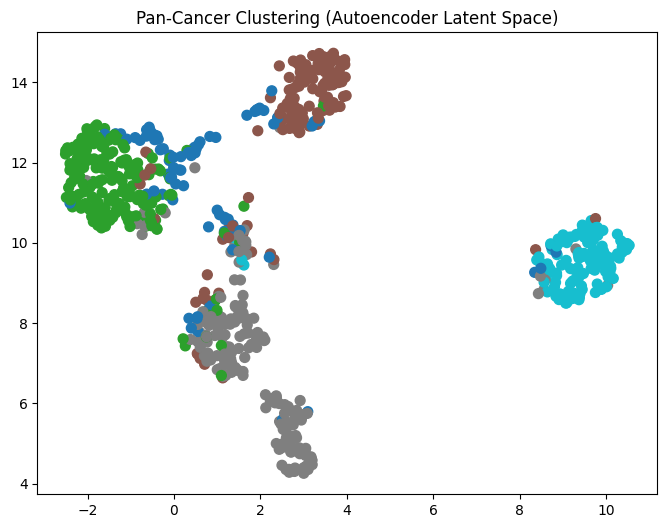

In [ ]:
import umap
import matplotlib.pyplot as plt

umap_2d = umap.UMAP(n_components=2, random_state=42)
embedding = umap_2d.fit_transform(latent_vectors)

plt.figure(figsize=(8,6))
plt.scatter(embedding[:,0], embedding[:,1], c=labels, cmap='tab10', s=50)
plt.title("Pan-Cancer Clustering (Autoencoder Latent Space)")
plt.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


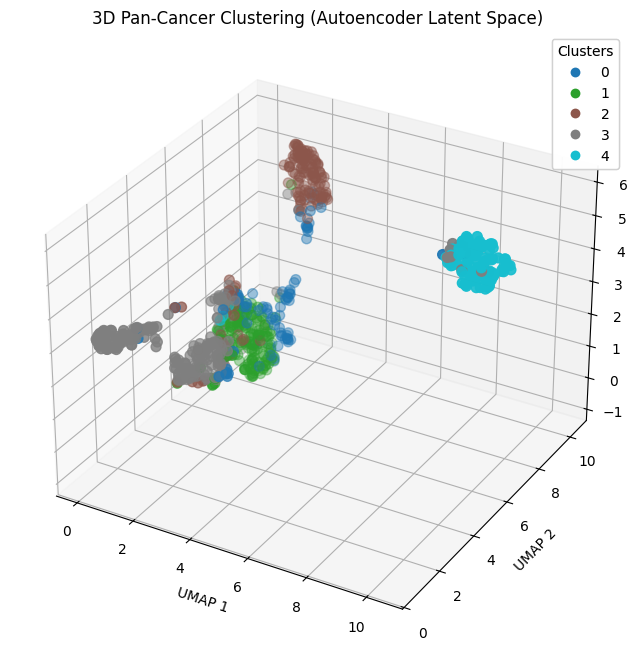

In [ ]:
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting

# 3D UMAP
umap_3d = umap.UMAP(n_components=3, random_state=42)
embedding_3d = umap_3d.fit_transform(latent_vectors)

# 3D scatter plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    embedding_3d[:,0],
    embedding_3d[:,1],
    embedding_3d[:,2],
    c=labels, cmap='tab10', s=50
)

ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
ax.set_title("3D Pan-Cancer Clustering (Autoencoder Latent Space)")

# Optional: add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


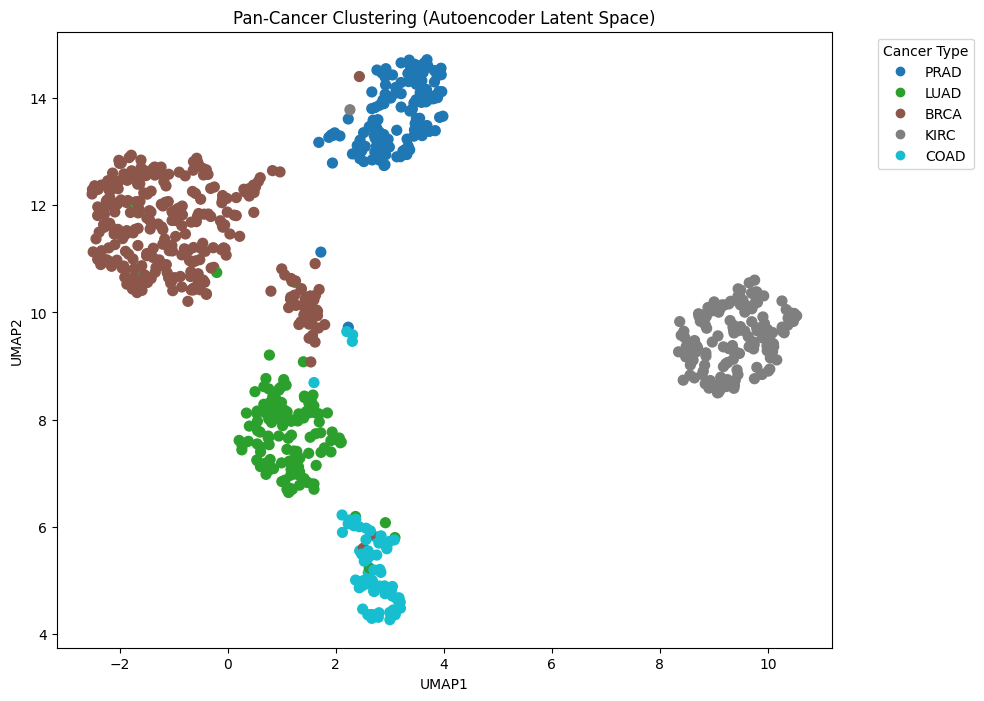

In [ ]:
import umap
import matplotlib.pyplot as plt
import pandas as pd

# Load labels
df2 = pd.read_csv("/content/labels.csv")

# Convert string labels to numeric
label_names = df2['Class'].unique()  # list of unique cancer types
label_to_num = {name: i for i, name in enumerate(label_names)}
numeric_labels = df2['Class'].map(label_to_num)

# UMAP on latent vectors
umap_2d = umap.UMAP(n_components=2, random_state=42)
embedding = umap_2d.fit_transform(latent_vectors)

# Scatter plot
plt.figure(figsize=(10,8))
scatter = plt.scatter(embedding[:,0], embedding[:,1], c=numeric_labels, cmap='tab10', s=50)

# Legend
handles, _ = scatter.legend_elements()
plt.legend(handles, label_names, title="Cancer Type", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Pan-Cancer Clustering (Autoencoder Latent Space)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()



## 3D UMAP plot

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


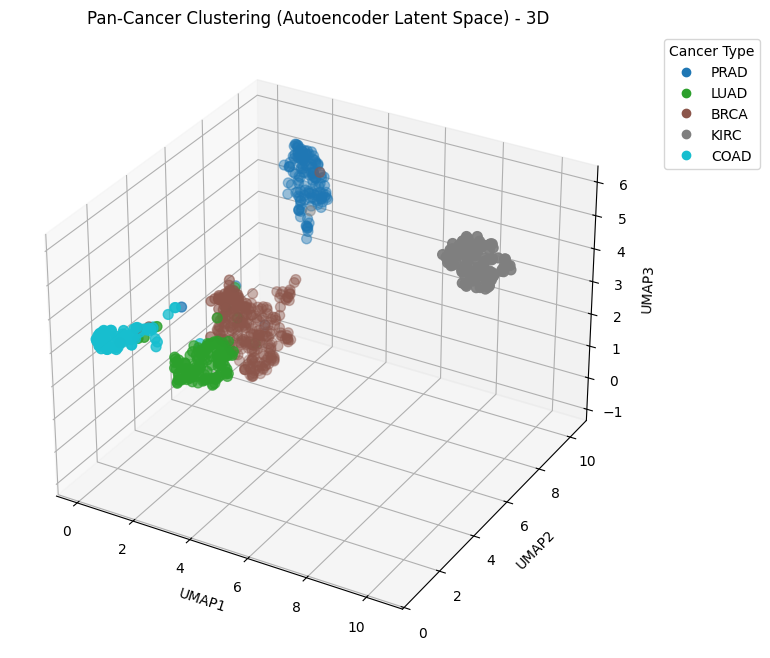

In [ ]:
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Load labels
df2 = pd.read_csv("/content/labels.csv")

# Convert string labels to numeric
label_names = df2['Class'].unique()  # unique cancer types
label_to_num = {name: i for i, name in enumerate(label_names)}
numeric_labels = df2['Class'].map(label_to_num)

# UMAP 3D on latent vectors
umap_3d = umap.UMAP(n_components=3, random_state=42)
embedding_3d = umap_3d.fit_transform(latent_vectors)

# 3D Scatter plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(embedding_3d[:,0], embedding_3d[:,1], embedding_3d[:,2],
                c=numeric_labels, cmap='tab10', s=50)

# Legend
handles, _ = sc.legend_elements()
ax.legend(handles, label_names, title="Cancer Type", bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_title("Pan-Cancer Clustering (Autoencoder Latent Space) - 3D")
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.set_zlabel("UMAP3")
plt.show()


In [ ]:
import plotly.express as px
# Convert string labels to numeric (optional for colors)
df2['Class'] = df2['Class'].astype(str)

# UMAP 3D on latent vectors
umap_3d = umap.UMAP(n_components=3, random_state=42)
embedding_3d = umap_3d.fit_transform(latent_vectors)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'UMAP1': embedding_3d[:,0],
    'UMAP2': embedding_3d[:,1],
    'UMAP3': embedding_3d[:,2],
    'CancerType': df2['Class']
})

# Interactive 3D scatter plot
fig = px.scatter_3d(
    plot_df,
    x='UMAP1',
    y='UMAP2',
    z='UMAP3',
    color='CancerType',
    title='Pan-Cancer Clustering (Autoencoder Latent Space)',
    width=800,
    height=600
)

fig.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


**Homogeneous clusters**: If a cluster mainly contains samples of one cancer type, it shows that gene expression profiles are distinct enough to separate cancers.

**Mixed clusters**: If a cluster contains multiple cancer types, it may indicate:

Similar molecular patterns across those cancer types.

Potential mislabeling or biological overlap.

# Identify Rare Subtypes

Look for small clusters or isolated points within a cancer type.

These could correspond to rare genomic subtypes, which are exactly what you’re looking for.

You can quantify “rare” by cluster size or distance from the main cluster.

# Cluster Metrics (Optional)

To complement the visual interpretation, you can calculate:

Silhouette Score: How well-separated your clusters are.

Davies-Bouldin Index: Compactness vs. separation.

Cluster sizes: To identify rare groups quantitatively.

# genes that contribute most to cluster separation using a combination of differential expression analysis and latent space feature analysis

## Assign Clusters

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd

# Suppose latent_vectors is your autoencoder latent representation
n_clusters = 5  # You can adjust based on UMAP visualization
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latent_vectors)

# Add cluster labels to your dataframe
df_clusters = df1.copy()
df_clusters['cluster'] = cluster_labels


## Identify Cluster-specific Genes (Differential Expression)

This will give you the top 10 genes that differentiate each cluster.

In [ ]:
import numpy as np

# Separate features (genes) from cluster labels
genes = df1.columns[1:]  # skip the first column if it's an index
df_features = df1[genes]

# Compute mean expression per cluster
cluster_means = df_features.groupby(df_clusters['cluster']).mean()

# Compute differential expression (fold change vs rest)
fold_change = pd.DataFrame()
for cluster in cluster_means.index:
    rest = df_features[df_clusters['cluster'] != cluster].mean()
    fold_change_cluster = cluster_means.loc[cluster] - rest
    fold_change[cluster] = fold_change_cluster

# Top genes per cluster
top_genes_per_cluster = {}
for cluster in fold_change.columns:
    top_genes = fold_change[cluster].sort_values(ascending=False).head(10)
    top_genes_per_cluster[cluster] = top_genes.index.tolist()

top_genes_per_cluster


{0: ['gene_9225',
  'gene_15589',
  'gene_9254',
  'gene_18781',
  'gene_10068',
  'gene_2910',
  'gene_9178',
  'gene_13462',
  'gene_9226',
  'gene_17017'],
 1: ['gene_15589',
  'gene_706',
  'gene_9652',
  'gene_19661',
  'gene_13462',
  'gene_6876',
  'gene_17905',
  'gene_4598',
  'gene_5727',
  'gene_4599'],
 2: ['gene_9176',
  'gene_9175',
  'gene_12069',
  'gene_12995',
  'gene_203',
  'gene_18135',
  'gene_18745',
  'gene_9177',
  'gene_11250',
  'gene_3737'],
 3: ['gene_3540',
  'gene_15898',
  'gene_3541',
  'gene_1189',
  'gene_6594',
  'gene_5017',
  'gene_18383',
  'gene_15894',
  'gene_2506',
  'gene_11249'],
 4: ['gene_219',
  'gene_16169',
  'gene_3439',
  'gene_16132',
  'gene_6733',
  'gene_220',
  'gene_1510',
  'gene_11566',
  'gene_19153',
  'gene_16392']}

## Heatmap for Visualization

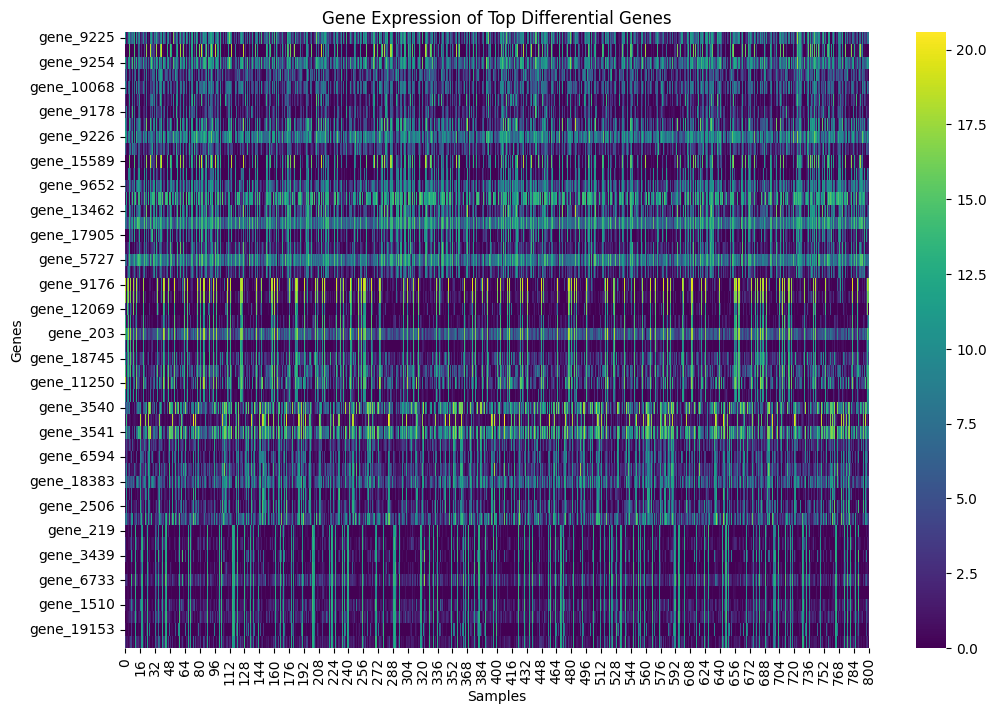

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select genes to plot
selected_genes = sum(top_genes_per_cluster.values(), [])

plt.figure(figsize=(12,8))
sns.heatmap(df_features[selected_genes].T, cmap='viridis')
plt.title("Gene Expression of Top Differential Genes")
plt.xlabel("Samples")
plt.ylabel("Genes")
plt.show()


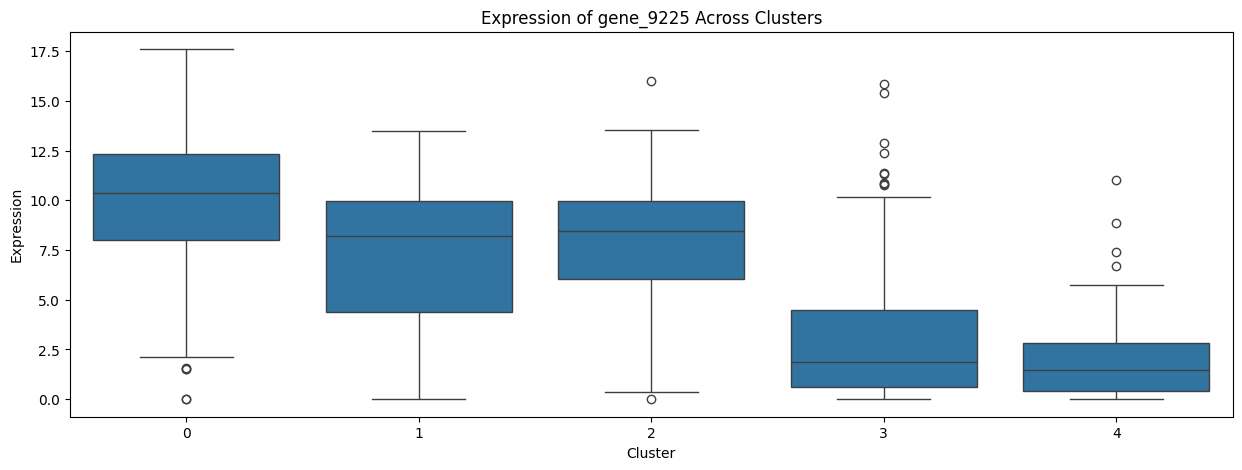

In [ ]:
plt.figure(figsize=(15,5))
top_gene = top_genes_per_cluster[0][0]  # take top gene from cluster 0 as example
sns.boxplot(x=df_clusters['cluster'], y=df_features[top_gene])
plt.title(f"Expression of {top_gene} Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Expression")
plt.show()